In [92]:
import os
import re 
import glob
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import tensorflow as tf
import tensorflow.keras as keras

# For gif creation
import imageio

In [93]:
!pip install -q git+https://github.com/tensorflow/docs
from tensorflow_docs.vis import embed


In [94]:
train_df = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')

print("num of rows:", len(train_df))
train_df.head()

num of rows: 585


,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


1    307
0    278
Name: MGMT_value, dtype: int64


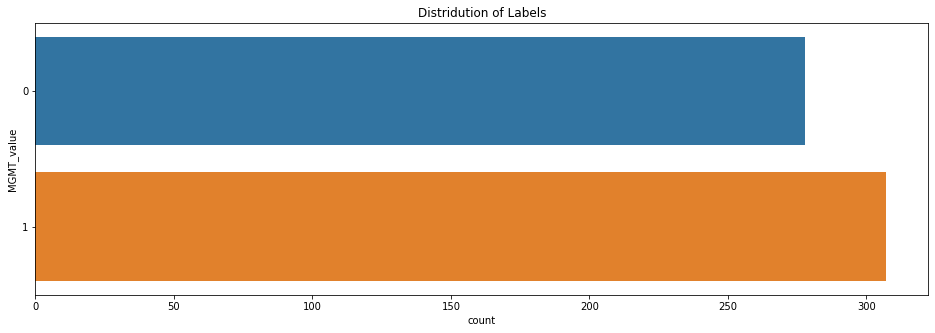

In [95]:
plt.figure(figsize=(16,5))
ax = sns.countplot(data=train_df, y="MGMT_value")
ax.set_title("Distridution of Labels")
print(train_df.MGMT_value.value_counts())

## Helper Functions

In [96]:
def ReadMRI(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    
    return data


# https://stackoverflow.com/a/2669120/7636462
def sorted_nicely(l): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)


def get_patient_id(patient_id):
    if patient_id < 10:
        return '0000'+str(patient_id)
    elif patient_id >= 10 and patient_id < 100:
        return '000'+str(patient_id)
    elif patient_id >=100 and patient_id < 1000:
        return '00'+str(patient_id)
    else:
        return '0'+str(patient_id)
    
    
def to_gif(images, savepath, fps=25):
  imageio.mimsave(savepath, images, fps=fps)
  return embed.embed_file(savepath)

def resize(image, target_size):
    zoom_factor = [target_size[i] / image.shape[i] for i in range(len(image.shape))]
    image = sp.ndimage.zoom(image, zoom=zoom_factor)
    
    return image

In [97]:
# show a chosen patient's data
# patient_ids = os.listdir('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train')
# IDX = np.random.choice(len(patient_ids))
# patient_id = patient_ids[IDX]


In [98]:
def read_patient(pid):
    # transform pid 
    label = train_df.loc[pid, 'MGMT_value']
    _patient_id = get_patient_id(train_df.loc[pid, 'BraTS21ID'])
    
    data = {}
    for scantype in ['FLAIR', 'T1w', 'T1wCE', 'T2w']:
        # read data
        scan_base = f'../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/{_patient_id}/{scantype}/' 

        scan_filenames = os.listdir(scan_base)
        scan_filenames = sorted_nicely(scan_filenames)
        scan_filenames =[os.path.join(scan_base, filename) for filename in scan_filenames]

        scan_data = [ReadMRI(filename) for filename in scan_filenames]
        scan_data = np.stack(scan_data, axis=0)
    
        data[scantype] = scan_data
    
#     print(_patient_id)
    return data, label
    
# data, label = read_patient(21)
# print(data['FLAIR'].shape)
# print(data['T1w'].shape)
# print(data['T1wCE'].shape)
# print(data['T2w'].shape)

# print(label)

In [99]:
# resized_image = resize(data['FLAIR'], (100, 256, 256))

In [100]:
# resized_image.shape

In [101]:
# from tensorflow_docs.vis import embed

# savepath = '/kaggle/working/1_FLAIR.gif'
# to_gif(data['FLAIR'], savepath)

In [102]:
# savepath = '/kaggle/working/1_T1w.gif'
# to_gif(data['T1w'], savepath)

In [103]:
# savepath = '/kaggle/working/1_T1wCE.gif'
# to_gif(data['T1wCE'], savepath)

In [104]:
# savepath = '/kaggle/working/1_T2w.gif'
# to_gif(data['T2w'], savepath)

In [105]:
# def plot_3d_image(image, interval=10):
#     xx, yy = np.meshgrid(np.linspace(0,1,image.shape[1]), np.linspace(0,1,image.shape[2]))

#     fig = plt.figure()
#     ax = Axes3D(fig)
#     for i in tqdm(range(len(image))):
#         zz = np.zeros_like(xx) + interval
#         data = image[i]
#         ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, facecolors=plt.cm.BrBG(data), shade=False)
    
#     plt.show()

In [106]:
class NNModel(keras.Model):
    def __init__(self):
        super().__init__()
        
        self.num_conv_layers = 6
        self.conv_filters =      [16,     64,     128,        256,      512,         512]
        self.conv_kernel_sizes = [7,      7,      7,          7,        (5, 7, 7),   4]
        self.pool_kernel_sizes = [3,      3,      (1, 3, 3),  None,     None,        None]
        self.bm_or_not =         [True,   True,   True,       True,     True,        True]
        
        self.convs = []
        self.pools = []
        self.bms   = []
        
        for i in range(self.num_conv_layers):
            if self.conv_filters[i]:
                self.convs.append(keras.layers.Conv3D(self.conv_filters[i], self.conv_kernel_sizes[i], activation='relu'))
            else:
                self.convs.append(None)
            
            if self.pool_kernel_sizes[i]:
                self.pools.append(keras.layers.MaxPool3D(pool_size=self.pool_kernel_sizes[i], strides=None, padding='valid', data_format=None))
            else:
                self.pools.append(None)
                
            if self.bm_or_not[i]:
                self.bms.append(keras.layers.BatchNormalization())
            else:
                self.bms.append(None)

        self.flatten = keras.layers.Flatten()
        
        self.num_linear_layers = 2
        self.linear_dims = [512, 1]
        
        self.linears = []
        
        for i in range(self.num_linear_layers):
            self.linears.append(keras.layers.Dense(self.linear_dims[i], activation='relu'))
        
    def call(self, x, verbos=0):
        for i in range(self.num_conv_layers):
            if self.convs[i]:
                x = self.convs[i](x)
            if self.pools[i]:
                x = self.pools[i](x)
            if self.bms[i]:
                x = self.bms[i](x)
            
            if verbos > 0:
                print('ok', x.shape)
            
        x = self.flatten(x)
        
        for i in range(self.num_linear_layers):
            x = self.linears[i](x)
            if verbos > 0:
                print('ok', x.shape)
        
        return x

In [107]:
nn = NNModel()
nn.build(input_shape=(None, 204, 512, 512, 1))
nn.summary()

Model: "nn_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           multiple                  5504      
_________________________________________________________________
conv3d_13 (Conv3D)           multiple                  351296    
_________________________________________________________________
conv3d_14 (Conv3D)           multiple                  2809984   
_________________________________________________________________
conv3d_15 (Conv3D)           multiple                  11239680  
_________________________________________________________________
conv3d_16 (Conv3D)           multiple                  32113152  
_________________________________________________________________
conv3d_17 (Conv3D)           multiple                  16777728  
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 multiple                  0

In [108]:
# x = tf.random.normal((1, 204, 512, 512, 1))
# output = nn(x)

In [109]:
# print(output.shape)

In [130]:
sample = read_patient(21)[0]['FLAIR'].astype(float)
sample = resize(sample, (128, 256, 256))
sample = sample.reshape(1, 128, 256, 256, 1)
sample = tf.convert_to_tensor(sample)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [134]:
### Training process

    
def save_hidden_images(sample, model, epoch, itr):
    prob = model(sample)
    
    for i, conv in enumerate(model.convs):
        for j in range(conv.output_.shape[-1]):
            basepath = f"/kaggle/working/train/images_{epoch}/iteration_{itr}/conv_{i}"
            os.makedirs(basepath, exist_ok=True)
            to_gif(conv.output_[0, :, :, :, i], savepath=os.path.join(basepath, "channel_{j}.gif"))


def train(dataset, model, batch_size=5, EPOCHS=3, submission=False):
    dataset = dataset.batch(batch_size)
    
    optimizer = keras.optimizers.Adam()
    loss_func = keras.losses.BinaryCrossentropy()
    
    
    @tf.function
    def train_step(images, label):
        with tf.GradientTape() as tape:
            output = model(images)
            loss = loss_func(label, output)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    
    for epoch in range(EPOCHS):
        print(f"start epoch {epoch}")
        for itr, (images, label) in tqdm(enumerate(dataset)):
            train_step(images, label)

            if itr % 100 == 0 and (not submission):
                save_hidden_images(sample, model, epoch + 1, itr + 1)

#         checkpoint.save(file_prefix = checkpoint_prefix)

  # 最后一个 epoch 结束后生成图片
    save_hidden_images(model, "last", 0)
    
    return model

In [111]:
def get_brain_tumor_train_dataset(using='FLAIR', maxlen=None):
    train_df = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')
    
    labels = list(train_df['MGMT_value'])
    if maxlen:
        labels = labels[:maxlen]
        
    
        
    def data_generator():
        data_size = min(maxlen, len(train_df)) if maxlen else len(train_df)
        random_idx = list(range(data_size))
        np.random.shuffle(random_idx)
        for i in range(data_size):
            j = random_idx[i]
            data, label = read_patient(j)
            img = data[using]
            img = resize(img, (128, 256, 256))
            img = img.reshape(128, 256, 256, 1).astype(float)
            yield img, labels[j]

    
    train_dataset = tf.data.Dataset.from_generator(data_generator, (tf.float32, tf.int64))
    
    print("successfully load dataset")
    
    return train_dataset

In [112]:
class BTD(keras.Model):
    """ BTD stands for brain-tumor-detection """
    def __init__(self):
        super().__init__()
    
        self.num_conv_layers = 6
        self.conv_filters =      [16,     64,     128,        256,        512,          512]
        self.conv_kernel_sizes = [7,      7,      7,          5,          3,            8]
        self.conv_padding      = ['same', 'same', 'same',     'same',     'same',      'valid']
        self.pool_kernel_sizes = [2,      2,      2,          2,          (1, 2, 2),   None]
        self.bm_or_not =         [True,   True,   True,       True,       True,        True]
        
        self.convs = []
        self.pools = []
        self.bms   = []
        
        for i in range(self.num_conv_layers):
            if self.conv_filters[i]:
                self.convs.append(keras.layers.Conv3D(self.conv_filters[i], self.conv_kernel_sizes[i], activation='relu', padding=self.conv_padding[i]))
            else:
                self.convs.append(None)
            
            if self.pool_kernel_sizes[i]:
                self.pools.append(keras.layers.MaxPool3D(pool_size=self.pool_kernel_sizes[i], strides=None, padding='valid', data_format=None))
            else:
                self.pools.append(None)
                
            if self.bm_or_not[i]:
                self.bms.append(keras.layers.BatchNormalization())
            else:
                self.bms.append(None)

        self.flatten = keras.layers.Flatten()
        
        self.num_linear_layers = 2
        self.linear_dims        = [512,       1]
        self.linear_activations = ['relu',    'sigmoid']
        
        self.linears = []
        
        for i in range(self.num_linear_layers):
            self.linears.append(keras.layers.Dense(self.linear_dims[i], activation=self.linear_activations[i]))
        
    def call(self, x, verbos=0):
        for i in range(self.num_conv_layers):
            if self.convs[i]:
                x = self.convs[i](x)
                self.convs[i].output_ = x
            if self.pools[i]:
                x = self.pools[i](x)
                self.pools[i].output_ = x
            if self.bms[i]:
                x = self.bms[i](x)
                self.bms[i].output_ = x
                
            if verbos > 0:
                print('ok', x.shape)
            
        x = self.flatten(x)
        
        for i in range(self.num_linear_layers):
            x = self.linears[i](x)
            
            if verbos > 0:
                print('ok', x.shape)
        
        return x

In [113]:
btd = BTD()
btd.build(input_shape=(None, 128, 256, 256, 1))
btd.summary()

Model: "btd_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_18 (Conv3D)           multiple                  5504      
_________________________________________________________________
conv3d_19 (Conv3D)           multiple                  351296    
_________________________________________________________________
conv3d_20 (Conv3D)           multiple                  2809984   
_________________________________________________________________
conv3d_21 (Conv3D)           multiple                  4096256   
_________________________________________________________________
conv3d_22 (Conv3D)           multiple                  3539456   
_________________________________________________________________
conv3d_23 (Conv3D)           multiple                  134218240 
_________________________________________________________________
max_pooling3d_11 (MaxPooling multiple                  0     

In [135]:
train_dataset = get_brain_tumor_train_datfaset(using='FLAIR')

trained_btd = train(train_dataset, btd, batch_size=1)

0it [00:00, ?it/s]

successfully load dataset
start epoch 0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
13it [03:15, 15.07s/it]


KeyboardInterrupt: 